## Numba library for speeding up things

In [1]:
from numba import jit

## GRR functions

In [2]:
@jit(nopython=True)
def GRR(x, lst_val, p, q):
    """
    GRR mechanism
    input: true value x, domain values 'lst_val', and probabilities p,q
    output: true value w.p. 'p', random value (except x) w.p. 'q'
    """
    
    rnd = np.random.random()

    if rnd <=p:    
        return x
    else:
        return np.random.choice(lst_val[lst_val !=x]) 


def SB_GRR(p, q , lst_val, lst):
    """
    Estimation on the number/frequency of times each value has been reported.
    input: probabilities p and q, domain values 'lst_val', and the list of reports 'lst'
    output: estimated frequency
    """
    
    n = len(lst)
    
    Ni = {val:0 for val in lst_val}
    
    for val in lst: #how many times each value has been reported
        Ni[val]+=1
    
    for key in Ni.keys(): #estimated number of times with Eq. (1)
        est = (Ni[key] - n*q) / (p-q)
        if est > 0:
            Ni[key] = est
        else: # if negative, we'll clip to 0 and re-normalize.
            Ni[key] = 0
    total = sum(Ni.values()) #for re-normalization
    for key in Ni.keys():
        Ni[key] = Ni[key]/total
    return np.array(list(Ni.values()))

## Function to know the combination's day of users: list_db

In [4]:
def lst_of_keys(days,dic_dates):
    """
    This function is used to find the databases (days) 
    to store the private data of users. 
    
    input:
    -days is a string of the days a user was present, e.g., 4321;
    -dic_dates is the set of databases.
    
    output:
    -lst_keys is a list of databases 'keys'.
    """
    lst_keys = []
    
    if len(days) == 1:
        for key in dic_dates.keys():
            if days[0] in key:
                lst_keys.append(key)
        return lst_keys
    else:
        for key in dic_dates.keys():
            if (days[0] in key) & (np.array([day not in key for day in days[1:]]).all()):
                lst_keys.append(key)
        return lst_keys

## Main libraries

In [5]:
import pandas as pd
pd.set_option('mode.chained_assignment',None)
#pd.set_option('display.max_rows', 500)
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import copy
from scipy.stats import bernoulli
import datetime
import time

## The dataset we use is from: https://github.com/hharcolezi/OpenMSFIMU

### Reading dataset

In [6]:
url1 = 'https://raw.githubusercontent.com/hharcolezi/OpenMSFIMU/master/Data/Relational_table.csv'
url2 = "https://raw.githubusercontent.com/hharcolezi/OpenMSFIMU/master/Data/Personal_table.csv"

fimu=['2017-05-31','2017-06-01','2017-06-02','2017-06-03','2017-06-04','2017-06-05','2017-06-06']

df_rel = pd.read_csv(url1, error_bad_lines=False)
df_per = pd.read_csv(url2, error_bad_lines=False)
df = df_rel.set_index('Person ID').join(df_per.set_index('Person ID'))

df['Date'] = df['Date ID'].replace([1,2,3,4,5,6,7], fimu)
df = df.loc[(df['Visitor category']!='Foreign tourist')] # Only French users
df.reset_index(inplace=True)
df.head(5)

,Person ID,Date ID,Visit Duration,Name,Gender,Age,Geolife,Visitor category,Region,Sleeping area,Date
0,25,3,Duration 10h-18h,Adrien Allain-Maillard,M,<18,growing peri-urban,Resident,Franche-Comté,Agglomeration of Belfort,2017-06-02
1,25,4,Duration 7h,Adrien Allain-Maillard,M,<18,growing peri-urban,Resident,Franche-Comté,Agglomeration of Belfort,2017-06-03
2,26,1,Duration 10h-18h,Adrien Allard,M,<18,comfortable family pavilion,Resident,Franche-Comté,NR,2017-05-31
3,26,2,Duration 5h,Adrien Allard,M,<18,comfortable family pavilion,Resident,Franche-Comté,NR,2017-06-01
4,26,3,Duration 4h,Adrien Allard,M,<18,comfortable family pavilion,Resident,Franche-Comté,NR,2017-06-02


In [7]:
print('Dataset dimension:',df.shape)

Dataset dimension: (187375, 11)


In [8]:
print('Number of unique users:', len(set(df['Person ID'])))

Number of unique users: 87098


In [9]:
df.columns

Index(['Person ID', 'Date ID', 'Visit Duration', 'Name', 'Gender', 'Age',
       'Geolife', 'Visitor category', 'Region', 'Sleeping area', 'Date'],
      dtype='object')

In [10]:
print("Domain size of each category we're interested in:\n")
for col in ['Gender', 'Age', 'Geolife', 'Region','Sleeping area','Visit Duration']:
    print(col,':',len(set(df[col])))

Domain size of each category we're interested in:

Gender : 2
Age : 7
Geolife : 12
Region : 22
Sleeping area : 11
Visit Duration : 10


## Dataset to work with

In [11]:
attributes = ['Gender', 'Age','Geolife', 'Region','Sleeping area','Visit Duration']

df2anon = copy.deepcopy(df[['Gender', 'Age', 'Geolife', 'Region','Sleeping area','Visit Duration']])

LE = LabelEncoder()

lst_label = {val:[] for val in attributes}

for col in attributes:
    df2anon[col] = LE.fit_transform(df[col])
    lst_label[col] = list(set(df2anon[col]))

dfnew = pd.concat([df[['Person ID','Date','Date ID']],df2anon],axis=1)#,cp
dfnew

,Person ID,Date,Date ID,Gender,Age,Geolife,Region,Sleeping area,Visit Duration
0,25,2017-06-02,3,1,5,5,10,0,1
1,25,2017-06-03,4,1,5,5,10,0,7
2,26,2017-05-31,1,1,5,1,10,4,1
3,26,2017-06-01,2,1,5,1,10,4,5
4,26,2017-06-02,3,1,5,1,10,4,4
...,...,...,...,...,...,...,...,...,...
187370,88932,2017-06-06,7,1,5,5,10,3,6
187371,88933,2017-06-04,5,1,1,8,10,4,7
187372,88934,2017-05-31,1,1,2,7,10,4,0
187373,88934,2017-06-01,2,1,2,7,10,4,6


## Static parameters

In [14]:
# period of analysis
print('Days of FIMU', fimu)

#number of attributes (d=6)
n_dim = df2anon.shape[1]
print('d=', n_dim)

#number of unique users (n)
print('n=', len(set(df['Person ID'])))

#number of k dimensions
k_dim = 1
print('k=', k_dim)

Days of FIMU ['2017-05-31', '2017-06-01', '2017-06-02', '2017-06-03', '2017-06-04', '2017-06-05', '2017-06-06']
d= 6
n= 87098
k= 1


# Our proposed methodology

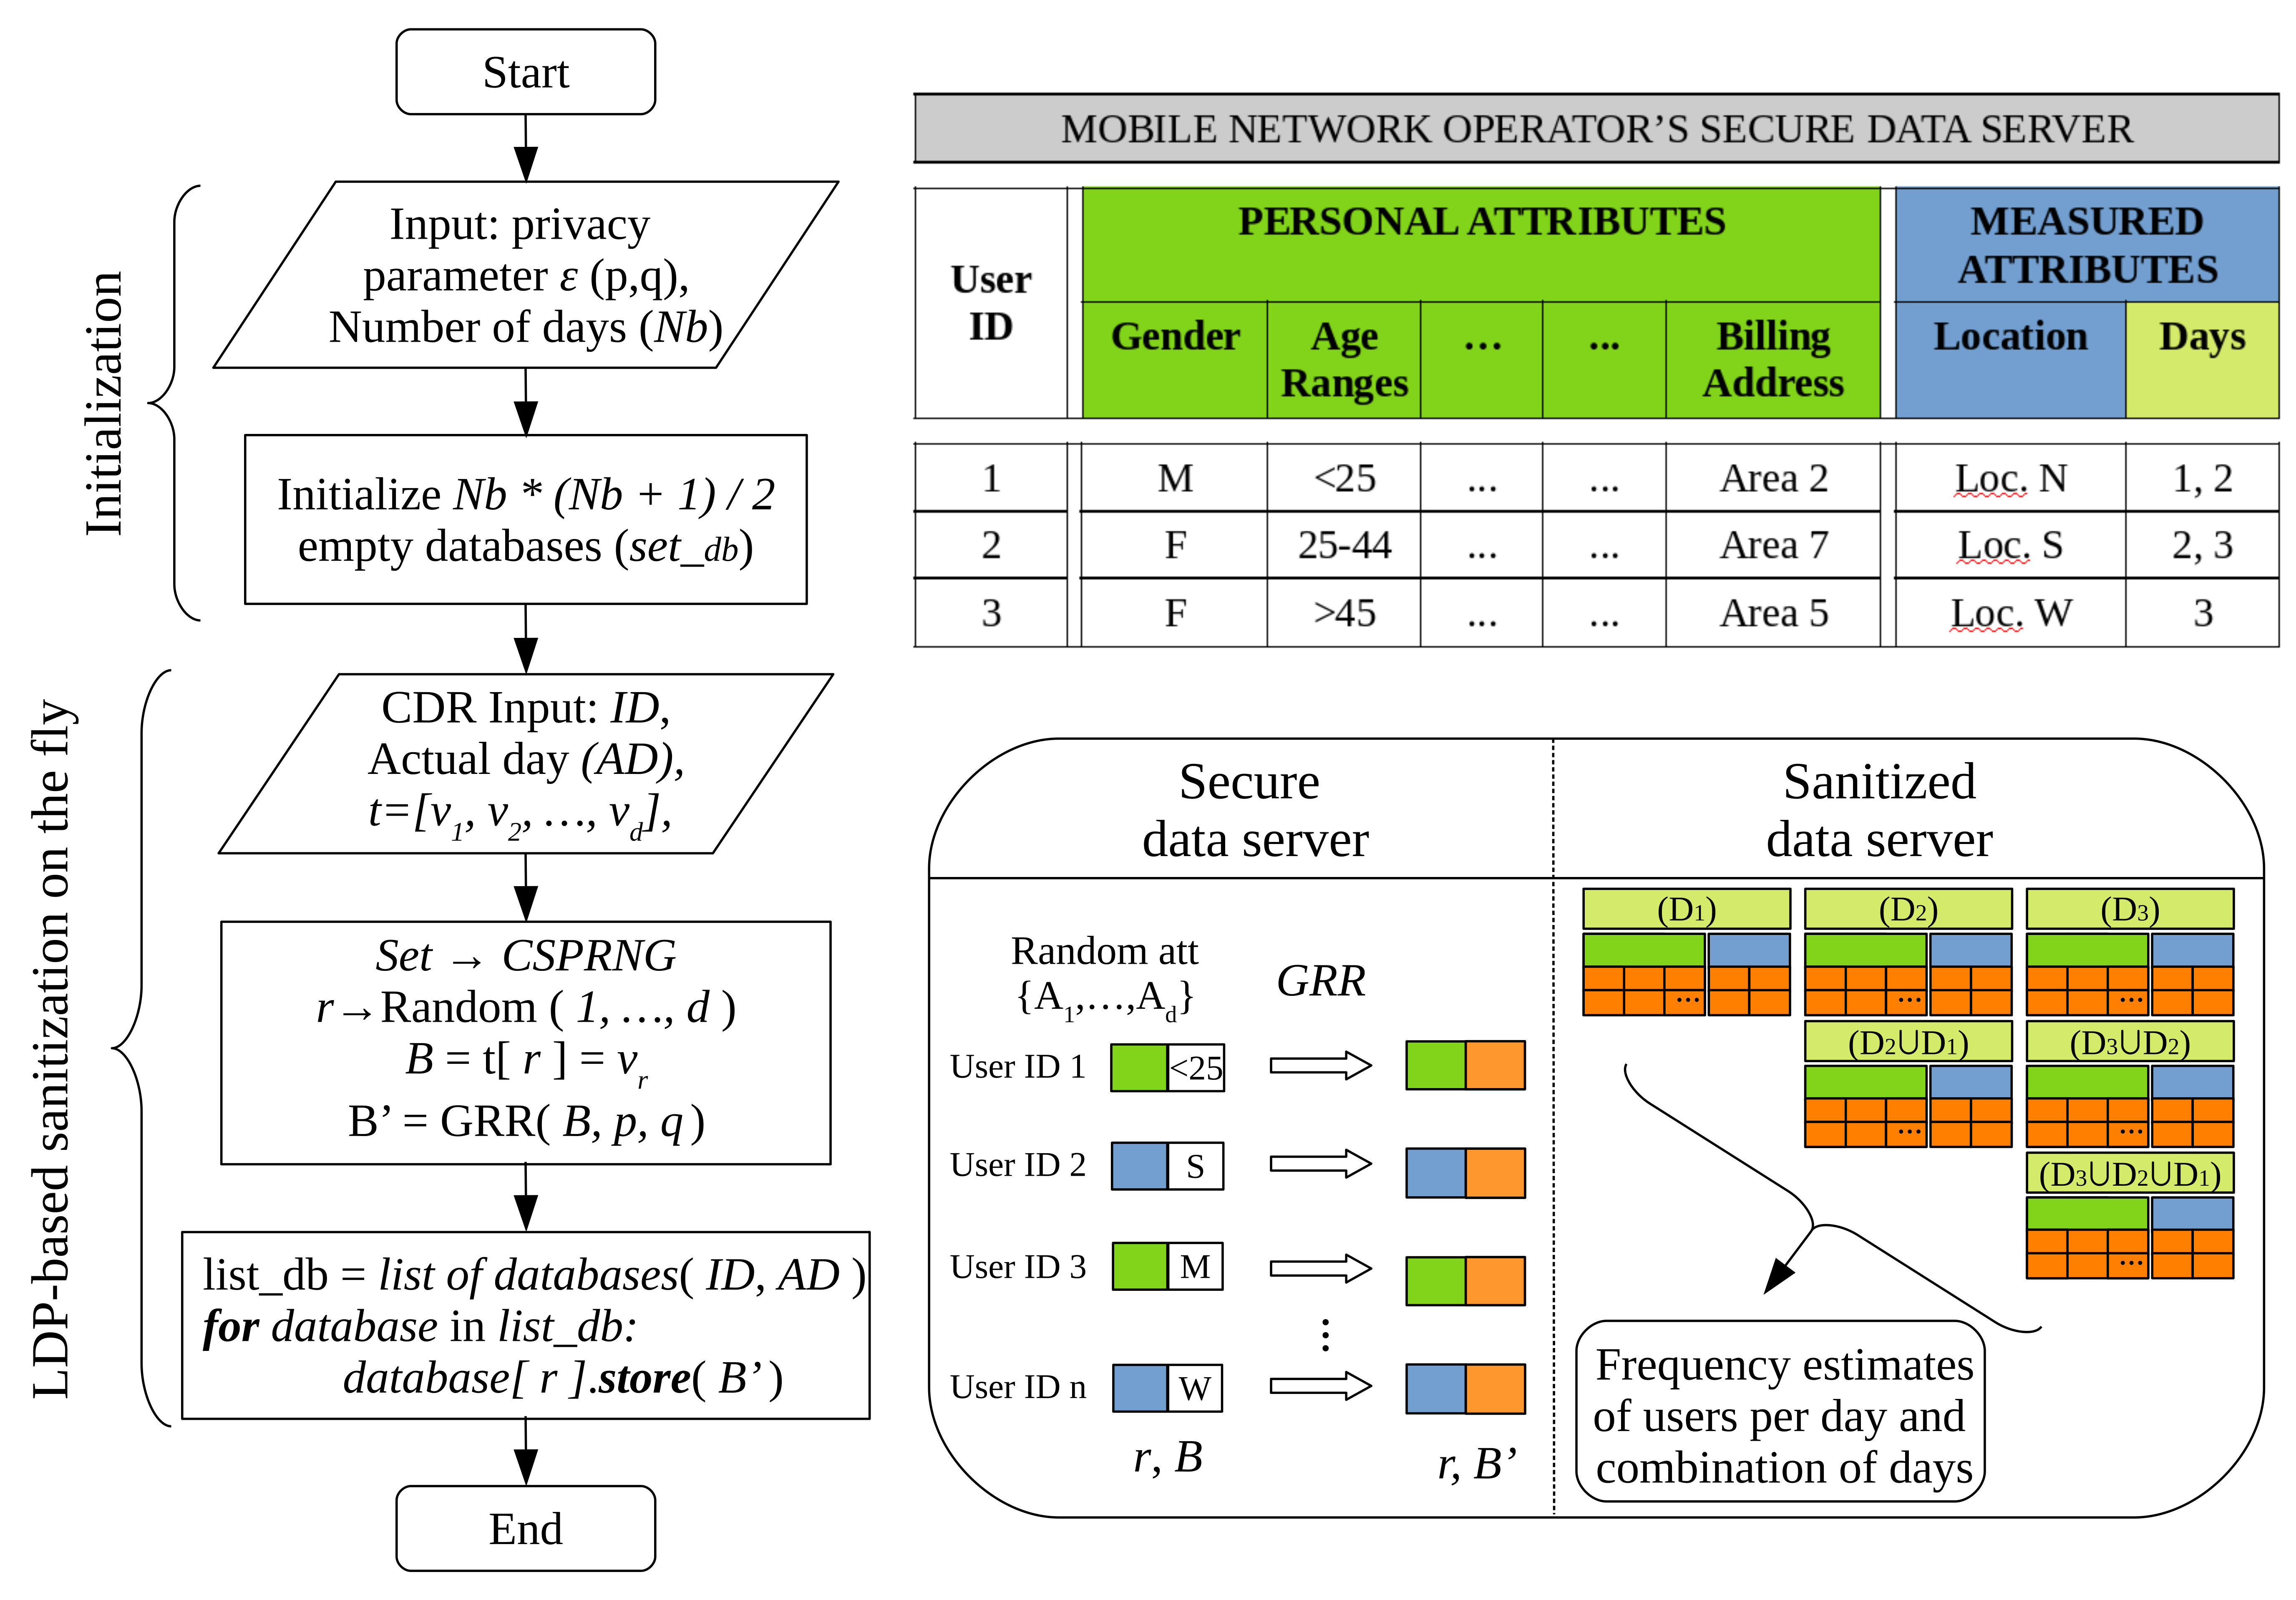

## LDP-based Privacy-Preserving Collection with GRR-M2, i.e., which samples a single attribute per user and uses the whole privacy budget

In [128]:
starttime = time.time()

seed = 42 # reproducibility

lst_eps = [1, 2 , 3] #[0.5, 1, 2, 3, 4, 5, 6]

# initialize dictionary to save RMSE result per epsilon
dic_RMSE = {}

for epsilon_tot in lst_eps: #the total privacy budget
    print("Starting analysis with epsilon total:",epsilon_tot)
    
    
    """Start creating empty databases + applying LDP for each user"""
    
    # Initialize set_db (set of empty databases to store LDP reports) as a dictionary
    # For each combination of day (e.g., '321' means day3 OR day2 OR day1), we have a key for each attribute
    set_db = {'1':{val:[] for val in attributes}, 
                 '2':{val:[] for val in attributes}, '21':{val:[] for val in attributes}, 
                 '3':{val:[] for val in attributes}, '32':{val:[] for val in attributes}, 
                 '321':{val:[] for val in attributes},'4':{val:[] for val in attributes}, 
                 '43':{val:[] for val in attributes}, '432':{val:[] for val in attributes}, 
                 '4321':{val:[] for val in attributes},'5':{val:[] for val in attributes}, 
                 '54':{val:[] for val in attributes}, '543':{val:[] for val in attributes}, 
                 '5432':{val:[] for val in attributes},'54321':{val:[] for val in attributes},
                 '6':{val:[] for val in attributes}, '65':{val:[] for val in attributes}, 
                 '654':{val:[] for val in attributes}, '6543':{val:[] for val in attributes}, 
                 '65432': {val:[] for val in attributes}, '654321':{val:[] for val in attributes},
                 '7':{val:[] for val in attributes}, '76':{val:[] for val in attributes}, 
                 '765':{val:[] for val in attributes}, '7654':{val:[] for val in attributes}, 
                 '76543':{val:[] for val in attributes}, '765432':{val:[] for val in attributes}, 
                 '7654321':{val:[] for val in attributes}}
 
    #seed to guarantee reproducibility per epsilon_tot
    np.random.seed(seed)
    
    # for each day in the FIMU
    for date in fimu: 
        print(f'{date}')

        # For each present user we do the following procedure
        for ind, row in dfnew.loc[dfnew['Date']==date].iterrows():  

            np.random.seed(int(row['Person ID'])) # Set the 'CSPRNG'
            
            #Using actual day and the ID of a user to get his present days
            days = ''.join([str(j) for j in dfnew['Date ID'].loc[(dfnew['Person ID']==row['Person ID'])&(dfnew['Date']<=row['Date'])].values])[::-1]
            
            #get the list_db of a user (i.e., the databases to store the users' LDP report)
            lst_keys = lst_of_keys(days, set_db)
                        
            """We randomly select k_dim=1 for a user
            to report his true info. The rest will not be reported"""

            #randomly select the attribute
            rand_dim = np.random.choice(attributes,1,replace=False).astype(object)[0]
            
            #Number of values of the selected attribute
            j = len(lst_label[rand_dim])
            
            # GRR parameters with the whole privacy budget
            p = np.exp(epsilon_tot)/(np.exp(epsilon_tot) + j - 1)
            q = (1-p)/(j-1)
            
            #sanitized value
            san_value = GRR(row[rand_dim], np.array(lst_label[rand_dim]), p, q)
            
            """We store the user's LDP reports in the respective
            databases in lst_keys"""
            for key in lst_keys:
                set_db[key][rand_dim].append(san_value)
        
    
    """Start Frequency Estimation + Calculate Error metrics"""
    
    # given epsilon, initialize a list to save RMSE result per combination of day
    lst_RMSE_day = []
    
    for key in set_db.keys():
        
        # given epsilon and the day, initialize a list to save estimated frequency per attribute
        lst_est_freq = []
        lst_real_freq = []
        for att in attributes:
            
            #Domain values of the attribute
            lst_val = lst_label[att]
            
            #Number of values of the attribute
            j = len(lst_label[att])
            
            # GRR parameters with the whole privacy budget
            p = np.exp(epsilon_tot)/(np.exp(epsilon_tot) + j - 1)
            q = (1-p)/(j-1)
                       
            # The estimated frequency for this attribute
            est_freq = list(SB_GRR(p, q , lst_val, set_db[key][att]))
            lst_est_freq += est_freq
            
            # The real frequency for this attribute
            
            Ri = {val:0 for val in lst_val}
    
            for val in dfnew.iloc[df['Person ID'].loc[(dfnew['Date ID']>=int(key[-1]))&(dfnew['Date ID']<=int(key[0]))].drop_duplicates().index][att].values: #how many times each value has been reported
                Ri[val]+=1
            
            real_freq = list(Ri.values())
            real_freq = np.array(real_freq)/sum(real_freq)
            lst_real_freq += list(real_freq)
            
        #save RMSE for this day taking all attributes into consideration
        lst_RMSE_day.append(np.sqrt(mean_squared_error(lst_real_freq, lst_est_freq)))
        
    #for each epsilon, we average the MSE by the number of days
    dic_RMSE[epsilon_tot] = np.mean(lst_RMSE_day)            
            
print('That took {} seconds'.format(time.time() - starttime))    

Starting analysis with epsilon total: 1
2017-05-31
2017-06-01
2017-06-02
2017-06-03
2017-06-04
2017-06-05
2017-06-06
Starting analysis with epsilon total: 2
2017-05-31
2017-06-01
2017-06-02
2017-06-03
2017-06-04
2017-06-05
2017-06-06
Starting analysis with epsilon total: 3
2017-05-31
2017-06-01
2017-06-02
2017-06-03
2017-06-04
2017-06-05
2017-06-06
That took 4172.173279047012 seconds


In [129]:
dic_RMSE

{1: 0.029053723443993963, 2: 0.008379547625574803, 3: 0.004537593667519566}

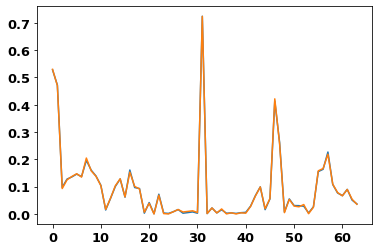

In [130]:
plt.plot(lst_real_freq)
plt.plot(lst_est_freq)

## Baseline (i.e., GRR-M1, which splits the privacy budget by the number of attributes)

In [131]:
starttime = time.time()

seed = 42

# initialize dictionary to save RMSE result per epsilon
dic_RMSE_Base = {}
 
for epsilon_tot in lst_eps: #the total privacy budget
    print("Starting analysis with epsilon total:",epsilon_tot)
    
    """Start creating empty databases + applying LDP for each user"""
    
    # Initialize set_db (set of empty databases to store LDP reports) as a dictionary
    set_db_Base = {'1':[], 
                 '2':[], '21':[], 
                 '3':[], '32':[], '321':[],
                 '4':[], '43':[], '432':[], '4321':[],
                 '5':[], '54':[], '543':[], '5432':[],'54321':[],
                 '6':[], '65':[], '654':[], '6543':[], '65432': [], '654321':[],
                 '7':[], '76':[], '765':[], '7654':[], '76543':[], '765432':[], '7654321':[]}

    #seed to guarantee reproducibility per epsilon_tot
    np.random.seed(seed)
    
    epsilon_split = epsilon_tot / n_dim # split the privacy budget per the number of attributes
    
    for date in fimu:  #We iterate for each day.
        print(f'{date}')

        # For each present user we do the following procedure
        for ind,row in dfnew.loc[dfnew['Date']==date].iterrows():  
            """For each user we do the following procedure."""

            np.random.seed(int(row['Person ID'])) # Set the 'CSPRNG'
            
            #Using actual day and the ID of a user to get his present days
            days = ''.join([str(j) for j in dfnew['Date ID'].loc[(dfnew['Person ID']==row['Person ID'])&(dfnew['Date']<=row['Date'])].values])[::-1]
            
            #get the list_db of a user (i.e., the databases to store the users' LDP report)
            lst_keys = lst_of_keys(days,set_db_Base)
            
            #list of sanitized values
            san_vector=[]
            for att in attributes:
                #Number of values of the attribute
                j = len(lst_label[att])
                
                # GRR parameters with the splitted privacy budget
                p = np.exp(epsilon_split)/(np.exp(epsilon_split) + j - 1)
                q = (1-p)/(j-1)
                
                san_vector.append(GRR(row[att], np.array(lst_label[att]), p, q))
            
            """We store the user's LDP reports in the respective
            databases in lst_keys"""
            for key in lst_keys:
                set_db_Base[key].append(san_vector)

    """Start Frequency Estimation + Calculate Error metrics"""
    
    # given epsilon, initialize a list to save RMSE result per combination of day
    lst_RMSE_day = []
    
    for key in set_db_Base.keys():
        
        # given epsilon and the day, initialize a list to save estimated frequency per attribute
        lst_est_freq = []
        lst_real_freq = []
        
        idx_att = 0
        for att in attributes:
            
            #Domain values of the attribute
            lst_val = lst_label[att]
            
            #Number of values of the attribute
            j = len(lst_label[att])
            
            # GRR parameters with the whole privacy budget
            p = np.exp(epsilon_split)/(np.exp(epsilon_split) + j - 1)
            q = (1-p)/(j-1)
                       
            # The estimated frequency for this attribute
            est_freq = list(SB_GRR(p, q , lst_val, [val[idx_att] for val in set_db_Base[key]]))
            lst_est_freq += est_freq
            
            # The real frequency for this attribute
            
            Ri = {val:0 for val in lst_val}
    
            for val in dfnew.iloc[df['Person ID'].loc[(dfnew['Date ID']>=int(key[-1]))&(dfnew['Date ID']<=int(key[0]))].drop_duplicates().index][att].values: #how many times each value has been reported
                Ri[val]+=1
            
            real_freq = list(Ri.values())
            real_freq = np.array(real_freq)/sum(real_freq)
            lst_real_freq += list(real_freq)
            idx_att+=1
            
        #save RMSE for this day taking all attributes into consideration
        lst_RMSE_day.append(np.sqrt(mean_squared_error(lst_real_freq, lst_est_freq)))
        
    #for each epsilon, we average the MSE by the number of days
    dic_RMSE_Base[epsilon_tot] = np.mean(lst_RMSE_day)            
    
print('That took {} seconds'.format(time.time() - starttime))    

Starting analysis with epsilon total: 1
2017-05-31
2017-06-01
2017-06-02
2017-06-03
2017-06-04
2017-06-05
2017-06-06
Starting analysis with epsilon total: 2
2017-05-31
2017-06-01
2017-06-02
2017-06-03
2017-06-04
2017-06-05
2017-06-06
Starting analysis with epsilon total: 3
2017-05-31
2017-06-01
2017-06-02
2017-06-03
2017-06-04
2017-06-05
2017-06-06
That took 4582.722012758255 seconds


In [132]:
dic_RMSE_Base

{1: 0.07482844716099998, 2: 0.047685857876355854, 3: 0.028250093234046175}

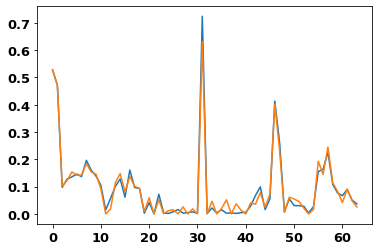

In [133]:
plt.plot(lst_real_freq)
plt.plot(lst_est_freq)

## Results

In [159]:
import matplotlib
params = {'axes.titlesize':'13',
          'xtick.labelsize':'13',
          'ytick.labelsize':'13',
          'font.size':'13',
          'legend.fontsize':'medium',
          'lines.linewidth':'1.5',
          'font.weight':'bold',
          'lines.markersize':'6'
          }
matplotlib.rcParams.update(params)

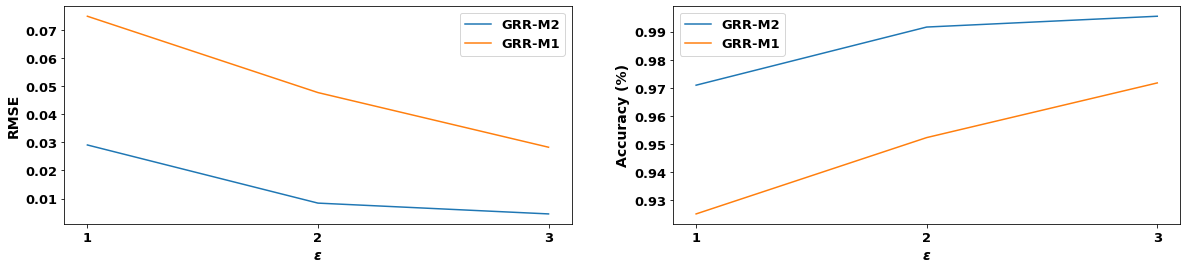

In [164]:
fig, ax = plt.subplots(1,2,figsize=(20,4))

ax[0].plot(lst_eps, dic_RMSE.values(), label='GRR-M2')
ax[0].plot(lst_eps, dic_RMSE_Base.values(), label='GRR-M1')
ax[0].set_ylabel('RMSE', fontweight='bold', fontsize=14)

ax[1].plot(lst_eps, [1-val for val in dic_RMSE.values()], label='GRR-M2')
ax[1].plot(lst_eps, [1-val for val in dic_RMSE_Base.values()], label='GRR-M1')
ax[1].set_ylabel('Accuracy (%)', fontweight='bold', fontsize=14)

for i in range(2):
    ax[i].set_xticks(lst_eps)
    ax[i].set_xticklabels(lst_eps)
    ax[i].set_xlabel('$\epsilon$', fontsize=14)
    ax[i].legend()